In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences

from deepctr.feature_column import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM

In [4]:
data = pd.read_csv("./data/movielens_sample.txt")

In [5]:
sparse_features = ["movie_id", "user_id",
                       "gender", "age", "occupation", "zip", ]

data[sparse_features] = data[sparse_features].astype(str)
target = ['rating']

In [6]:
# Use hashing encoding on the fly for sparse features, and process sequence features
genres_list = list(map(lambda x: x.split('|'), data['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)

# Notice : padding=`post`
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', dtype=object, value=0).astype(str)

In [10]:
# Set hashing space for each sparse field and generate feature config for sequence feature
fixlen_feature_columns = [SparseFeat(feat, data[feat].nunique() * 5, embedding_dim=4, use_hash=True, dtype='string')
                            for feat in sparse_features]
varlen_feature_columns = [
    VarLenSparseFeat(SparseFeat('genres', vocabulary_size=100, embedding_dim=4, use_hash=True, dtype="string"),
                        maxlen=max_len, combiner='mean',
                        )]  # Notice : value 0 is for padding for sequence input feature
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

In [12]:
# Generate input data for model
model_input = {name: data[name] for name in feature_names}
model_input['genres'] = genres_list

In [14]:
# Define Model,compile and train
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression')

model.compile("adam", "mse", metrics=['mse'], )
history = model.fit(model_input, data[target].values,
                    batch_size=256, epochs=100, verbose=2, validation_split=0.2, )

Epoch 1/100
1/1 - 3s - loss: 14.2999 - mse: 14.2999 - val_loss: 13.3752 - val_mse: 13.3752
Epoch 2/100
1/1 - 0s - loss: 14.1552 - mse: 14.1552 - val_loss: 13.2290 - val_mse: 13.2290
Epoch 3/100
1/1 - 0s - loss: 13.9880 - mse: 13.9880 - val_loss: 13.0714 - val_mse: 13.0714
Epoch 4/100
1/1 - 0s - loss: 13.8083 - mse: 13.8083 - val_loss: 12.8997 - val_mse: 12.8997
Epoch 5/100
1/1 - 0s - loss: 13.6127 - mse: 13.6127 - val_loss: 12.7115 - val_mse: 12.7115
Epoch 6/100
1/1 - 0s - loss: 13.3987 - mse: 13.3987 - val_loss: 12.5041 - val_mse: 12.5041
Epoch 7/100
1/1 - 0s - loss: 13.1641 - mse: 13.1641 - val_loss: 12.2762 - val_mse: 12.2762
Epoch 8/100
1/1 - 0s - loss: 12.9068 - mse: 12.9068 - val_loss: 12.0253 - val_mse: 12.0253
Epoch 9/100
1/1 - 0s - loss: 12.6239 - mse: 12.6239 - val_loss: 11.7490 - val_mse: 11.7490
Epoch 10/100
1/1 - 0s - loss: 12.3125 - mse: 12.3125 - val_loss: 11.4446 - val_mse: 11.4446
Epoch 11/100
1/1 - 0s - loss: 11.9693 - mse: 11.9693 - val_loss: 11.1091 - val_mse: 11.10

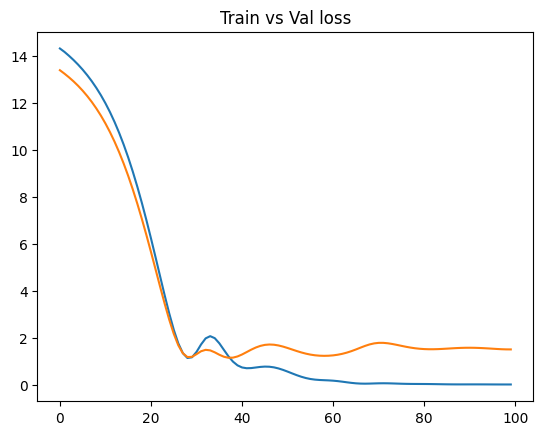

In [15]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)

plt.title("Train vs Val loss");